## Load necessary modules

In [14]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load RetinaNet model

In [15]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('saved_models', 'test.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'tops', 2: 'trousers', 3: 'outerwear', 4: 'dresses', 5: 'skirts'}

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

## Run detection on example

[{"image_id": 2, "category_id": 3, "bbox": [583, 106, 751, 1191], "score": 0.6545443534851074}, {"image_id": 21, "category_id": 3, "bbox": [79, 270, 509, 767], "score": 0.7162162065505981}, {"image_id": 21, "category_id": 3, "bbox": [621, 887, 543, 642], "score": 0.5969507694244385}, {"image_id": 356, "category_id": 3, "bbox": [3005, 1676, 1378, 1975], "score": 0.8254340887069702}, {"image_id": 356, "category_id": 3, "bbox": [228, 1597, 1676, 2054], "score": 0.7525813579559326}]
processing time:  1.3221395015716553
[ 583.77814  106.15024 1335.6859  1297.2842 ] 0.65454435 3


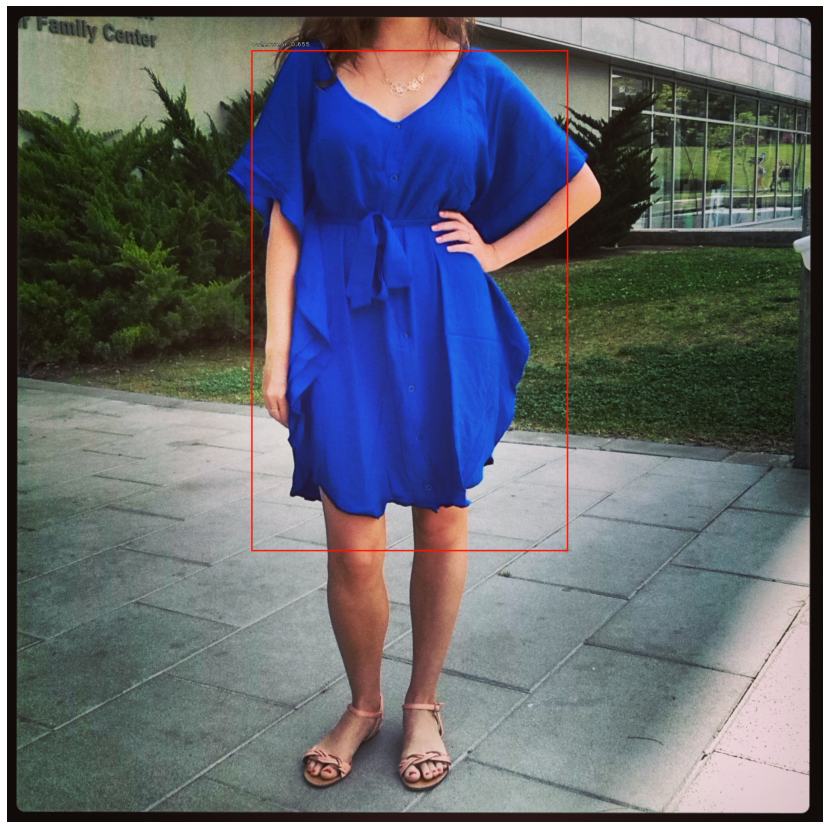

In [37]:
import glob

image_paths = []
for filename in glob.glob('images/*.jpg'):
    folder, file = filename.split('/')
    idx, typ = file.split('.')
    image_paths.append([int(idx), file])

res = []
for idx, image in image_paths:
    # load image
    image = read_image_bgr('images/'+image)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # extract boxes with greater than 0.5 confidence
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5: break

        # add to res
        x1, y1, x2, y2 = list(box)
        tmp = {
                "image_id": int(idx)+1,
                "category_id": int(label),
                "bbox": [
                    int(x1), int(y1), int(x2-x1), int(y2-y1)
                ],
                "score": float(score)
            }
        res.append(tmp)


res.sort(key=lambda x: x['image_id'])

import json
print(json.dumps(res))


####### FOR DRAWING IMAGE UNCOMMENT BELOW IF NOT DONT GIVE A FK ABT IT #################

# # load image
# image = read_image_bgr('images/1.jpg')

# # copy to draw on
# draw = image.copy()
# draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# # preprocess image for network
# image = preprocess_image(image)
# image, scale = resize_image(image)

# # process image
# start = time.time()
# boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
# print("processing time: ", time.time() - start)

# # correct for image scale
# boxes /= scale

# # visualize detections
# for box, score, label in zip(boxes[0], scores[0], labels[0]):
#     # scores are sorted so we can break
#     if score < 0.5:
#         break
#     print(box, score, label)
        
#     color = label_color(label)
    
#     b = box.astype(int)
#     draw_box(draw, b, color=color)
    
#     caption = "{} {:.3f}".format(labels_to_names[label], score)
#     draw_caption(draw, b, caption)
    
# plt.figure(figsize=(15, 15))
# plt.axis('off')
# plt.imshow(draw)
# plt.show()